### Google Play Review Crawling

In [1]:
# ! pip install google-play-scraper
import pandas as pd
from google_play_scraper import Sort, reviews

pd.set_option('display.max_colwidth', 500) 
pd.options.display.colheader_justify = 'left'

References
- https://github.com/JoMingyu/google-play-scraper
- https://simbbo-blog.tistory.com/190

In [2]:
# 최대 크롤링 리뷰 횟수 지정
count_per_request = 5000

# 크롤링 실행
result, continuation_token = reviews(
    'com.netmarble.tskgb'
    , lang = 'ko'
    , country = 'kr'
    , sort = Sort.NEWEST
    , count=count_per_request
)

In [3]:
# 빈 리스트 정의
reviewId_list = []
userName_list = []
content_list = []
score_list = []
thumsUpCount_list = []
at_list = []
replyContent_list = []

In [4]:
# 필요한 부분만 데이터프레임화
for i in range(0, len(result)):
    reviewId_list.append(result[i]['reviewId'])
    userName_list.append(result[i]['userName'])
    content_list.append(result[i]['content'])
    score_list.append(result[i]['score'])
    thumsUpCount_list.append(result[i]['thumbsUpCount'])
    at_list.append(result[i]['at'])
    replyContent_list.append(result[i]['replyContent'])

data = {
    'reviewId':reviewId_list
    , 'userName':userName_list
    , 'content':content_list
    , 'score':score_list
    , 'thumbsUpCount':thumsUpCount_list
    , 'at':at_list
    , 'replyContent':replyContent_list
}

df = pd.DataFrame(data)

In [5]:
# 크롤링 결과 확인
print('='*70)
display(df.head(3))
print('='*70)
df.info()

,reviewId,userName,content,score,thumbsUpCount,at,replyContent
0,ff551cf9-1afb-40c4-aecc-c740277f684f,Google 사용자,아니 게임 튕김현상 좀 고치라고 게임 잔렉 수정했다면서 그대로 있고 뭘 수정한거며 게임 유지관리는 뒷전이고 신규유닛으로 돈 빼먹을 생각밖에 안하나?,1,4,2025-06-09 13:24:19,None
1,0ecb5d0a-6dfd-4c9b-b533-12cd0636c9c1,Google 사용자,아니 뽑기확률 극악이네요 확정에서만 나오고 이건 뭐 하지말라는 소리인가요? 영웅이 좀 나와야 재미있게 하는데 열심히 루비 모아서 뽑으면 나오질 않으니 흥미가 사라지네요 이 다음 루뽑에서 전설 안나오면 접을게요 원작 하던 유저로서 이건 좀 아닌듯 싶습니다,1,1,2025-06-09 13:00:28,None
2,8f80333b-9c8f-4fa3-ad99-23f8c7c83ecd,Google 사용자,1점 주기도 아까운 게임.,1,1,2025-06-09 12:58:45,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reviewId       4332 non-null   object        
 1   userName       4332 non-null   object        
 2   content        4332 non-null   object        
 3   score          4332 non-null   int64         
 4   thumbsUpCount  4332 non-null   int64         
 5   at             4332 non-null   datetime64[ns]
 6   replyContent   2075 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 237.0+ KB


### Text Preprocessing

Reference
- https://github.com/bab2min/kiwipiepy
- https://youtu.be/llfvObDLp64?si=cBBVTEGI65TrFP2v

In [6]:
# ! pip install kiwipiepy
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

In [7]:
# 객체 지정
kiwi = Kiwi()
stopwords = Stopwords()

In [8]:
# 전처리용 데이터프레임 정의
processed_reviews = df[['content']].rename(columns={'content':'original_contents'})

In [9]:
# 각 리뷰를 토큰 리스트로 변환
tokenized_contents_list = []

for i in range(0, len(processed_reviews['original_contents'])):
    tokenized_content = kiwi.tokenize(
        processed_reviews.loc[i]['original_contents']
        , normalize_coda=True
        , stopwords=stopwords
        )
    # tokenized_contents_list 안에 각 리뷰별 token들을 모아둔 리스트가 들어감
    tokenized_contents_list.append(tokenized_content)   

In [10]:
# 토근 리스트를 원본 리뷰와 붙이기
processed_reviews['tokens'] = None

for i in range(0, len(tokenized_contents_list)):
    token_list = []
    for j in range(0, len(tokenized_contents_list[i])):
        # print(tokenized_contents_list[i][j].form)
        token_list.append(tokenized_contents_list[i][j].form)
    # print(token_list)
    processed_reviews.at[i, 'tokens']= token_list

processed_reviews.tail()

,original_contents,tokens
4327,우효 다운받는당,"[우효, 다운, 받, 는다, ᆼ]"
4328,레전드 상황 발생,"[레전드, 상황, 발생]"
4329,굿,[굿]
4330,추억의 게임이 돌아왔다,"[추억, 게임, 돌아오]"
4331,나이스,[나이스]


### LDA (: Latent Dirichlet Allocation)

#### (1) 필요한 라이브러리 설치 및 임포트

In [11]:
# ! pip install gensim pyldavis
import numpy as np
import matplotlib.pyplot as plt

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import warnings

# pyLDAvis 사용에 DeprecationWarning 오류 무시
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### (2) 데이터 준비

In [12]:
processed_reviews.head(5)

,original_contents,tokens
0,아니 게임 튕김현상 좀 고치라고 게임 잔렉 수정했다면서 그대로 있고 뭘 수정한거며 게임 유지관리는 뒷전이고 신규유닛으로 돈 빼먹을 생각밖에 안하나?,"[아니, 게임, 튕기, ᆷ, 현상, 좀, 고치, 라고, 게임, 잔렉, 수정, 다면서, 그대로, 뭐, ᆯ, 수정, 거, 게임, 유지, 관리, 뒷전, 신규, 유닛, 돈, 빼먹, 생각, 밖에, 안, 나]"
1,아니 뽑기확률 극악이네요 확정에서만 나오고 이건 뭐 하지말라는 소리인가요? 영웅이 좀 나와야 재미있게 하는데 열심히 루비 모아서 뽑으면 나오질 않으니 흥미가 사라지네요 이 다음 루뽑에서 전설 안나오면 접을게요 원작 하던 유저로서 이건 좀 아닌듯 싶습니다,"[아니, 뽑기, 확률, 극악, 네요, 확정, 나오, 이거, 뭐, 말, 소리, ᆫ가, 요, 영웅, 좀, 나오, 재미있, 는데, 열심히, 루비, 모으, 뽑, 으면, 나오, ᆯ, 으니, 흥미, 사라지, 네요, 다음, 루뽑, 전설, 안, 나오, 접, 을게요, 원작, 유저, 로서, 이거, 좀, 듯, 싶, 습니다]"
2,1점 주기도 아까운 게임.,"[1, 점, 주기, 아깝, 게임]"
3,버그는 안잡고 돈 써도 쫄은 안주고 소통 한다고 해놓고 아예 안하고 넥슨한테 쳐발리는 이유를 몸소 보여주네,"[버그, 안, 잡, 돈, 쓰, 어도, 쪼, 안, 주, 소통, ᆫ다고, 놓, 아예, 안, 넥슨, 한테, 치, 발리, 이유, 몸소, 보이, 네]"
4,소환권 쳐 내놔 나 벌써 20만원 썼어,"[소환, 권, 치, 내, 놓, 벌써, 20, 쓰]"


#### (3) 사전(Dictionary)과 말뭉치(Corpus) 생성

In [13]:
# 토큰 리스트로부터 Dictionary 생성
dictionary = corpora.Dictionary(processed_reviews['tokens'])

# 너무 희귀하거나 너무 흔한 단어 제거
dictionary.filter_extremes(no_below=5, no_above=0.8)

print(f"사전에 포함된 고유 단어 개수: {len(dictionary)}")

# 토큰 리스트를 BoW(Bag-of-Words) 형태로 변환하여 말뭉치(Corpus) 생성
corpus = [dictionary.doc2bow(doc) for doc in processed_reviews['tokens']]

print(f"생성된 말뭉치의 문서 개수: {len(corpus)}")
# 첫 번째 문서의 BoW 표현 확인 (예시)
print("첫 번째 문서의 BoW 표현:", corpus[0])
print("\n")


사전에 포함된 고유 단어 개수: 1783
생성된 말뭉치의 문서 개수: 4332
첫 번째 문서의 BoW 표현: [(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]




#### (4) 최적의 토픽 수 찾기

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    여러 개의 토픽 수에 대해 coherence 값을 계산하는 함수
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

# 여러 토픽 수에 대한 coherence 값 계산
print("다양한 토픽 수에 대한 coherence 값 계산 중...")
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=processed_reviews['tokens'], 
                                                        start=2, limit=20, step=2)

다양한 토픽 수에 대한 coherence 값 계산 중...


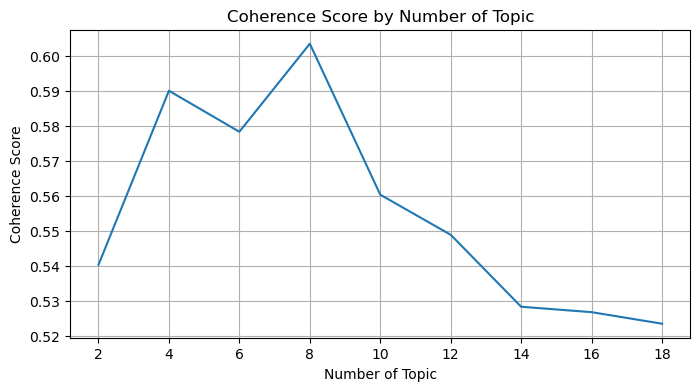

최적의 토픽 수: 8


In [15]:
# 최적의 토픽 수 시각화
limit=20
start=2
step=2
x = range(start, limit, step)
plt.figure(figsize=(8, 4))
plt.plot(x, coherence_values)
plt.xlabel("Number of Topic")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topic")
plt.xticks(x)
plt.grid(True)
plt.show()

# 최적의 토픽 수 확인
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f'최적의 토픽 수: {optimal_num_topics}')


#### (5) LDA 모델 학습

In [16]:
# 토픽 수 별도 지정
optimal_num_topics = 8

In [17]:
# 앞서 찾은 최적의 토픽 수로 LDA 모델 학습
print(f"LDA 모델 학습 시작 (토픽 수: {optimal_num_topics})...")
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)
print("LDA 모델 학습 완료.")
print("\n")

LDA 모델 학습 시작 (토픽 수: 8)...
LDA 모델 학습 완료.




#### (6) 토픽 분석

In [18]:
# 학습된 LDA 모델의 토픽 확인
print("LDA 모델 결과 - 각 토픽별 상위 단어:")
for idx, topic in lda_model.print_topics(num_words=15):
    print(f"토픽 {idx+1}: {topic}")
print("\n")

LDA 모델 결과 - 각 토픽별 상위 단어:
토픽 1: 0.128*"게임" + 0.068*"네요" + 0.061*"어요" + 0.053*"너무" + 0.049*"좋" + 0.040*"습니다" + 0.039*"추억" + 0.033*"보" + 0.033*"있" + 0.028*"재밌" + 0.022*"그래픽" + 0.017*"잘" + 0.016*"그렇" + 0.016*"폰" + 0.015*"가"
토픽 2: 0.067*"캐릭터" + 0.059*"스킬" + 0.028*"정말" + 0.026*"스토리" + 0.025*"연출" + 0.021*"수준" + 0.014*"설정" + 0.013*"던가" + 0.013*"자동" + 0.013*"어쩌" + 0.012*"디자인" + 0.012*"퀄리티" + 0.012*"낫" + 0.011*"전투" + 0.011*"2."
토픽 3: 0.070*"ᆸ니다" + 0.025*"심하" + 0.023*"번" + 0.017*"시" + 0.016*"으면" + 0.015*"많이" + 0.015*"삭제" + 0.014*"10" + 0.014*"5" + 0.014*"유저" + 0.013*"과금" + 0.013*"정도" + 0.012*"리버스" + 0.011*"팅" + 0.010*"25"
토픽 4: 0.070*"기대" + 0.045*"ᆫ지" + 0.032*"분" + 0.028*"냐" + 0.027*"세나1" + 0.027*"자" + 0.022*"다른" + 0.021*"전" + 0.020*"처럼" + 0.020*"니" + 0.020*"쫄작" + 0.020*"열쇠" + 0.017*"현상" + 0.017*"화면" + 0.012*"갤럭시"
토픽 5: 0.168*"나" + 0.106*"세" + 0.042*"옛날" + 0.038*"보다" + 0.036*"다시" + 0.033*"세븐나이츠" + 0.029*"시작" + 0.027*"생각" + 0.026*"재미" + 0.020*"알" + 0.017*"재미있" + 0.014*"ᆯ" + 0.012*"처음" + 0.012*"지금"

#### (7) LDA 결과 시각화 (pyLDAvis)

In [19]:
# pyLDAvis를 위한 준비
print("pyLDAvis 시각화 준비 중...")
vis = gensimvis.prepare(lda_model, corpus, dictionary)
print("pyLDAvis 시각화 준비 완료.")

# 시각화 결과를 HTML 파일로 저장
pyLDAvis.save_html(vis, f'lda_visualization_{optimal_num_topics}.html')
print("시각화 결과가 html 파일로 저장되었습니다.")
print("\n")

pyLDAvis 시각화 준비 중...
pyLDAvis 시각화 준비 완료.
시각화 결과가 html 파일로 저장되었습니다.




#### (8) 각 리뷰의 토픽 할당

데이터프레임에 지배적인 토픽 정보 추가 완료.
  tokens                                                                                                                                                                       \
0                                                              [아니, 게임, 튕기, ᆷ, 현상, 좀, 고치, 라고, 게임, 잔렉, 수정, 다면서, 그대로, 뭐, ᆯ, 수정, 거, 게임, 유지, 관리, 뒷전, 신규, 유닛, 돈, 빼먹, 생각, 밖에, 안, 나]   
1  [아니, 뽑기, 확률, 극악, 네요, 확정, 나오, 이거, 뭐, 말, 소리, ᆫ가, 요, 영웅, 좀, 나오, 재미있, 는데, 열심히, 루비, 모으, 뽑, 으면, 나오, ᆯ, 으니, 흥미, 사라지, 네요, 다음, 루뽑, 전설, 안, 나오, 접, 을게요, 원작, 유저, 로서, 이거, 좀, 듯, 싶, 습니다]   
2                                                                                                                                                          [1, 점, 주기, 아깝, 게임]   
3                                                                                              [버그, 안, 잡, 돈, 쓰, 어도, 쪼, 안, 주, 소통, ᆫ다고, 놓, 아예, 안, 넥슨, 한테, 치, 발리, 이유, 몸소, 보이, 네]   
4                                                                                        

<Figure size 1200x600 with 0 Axes>

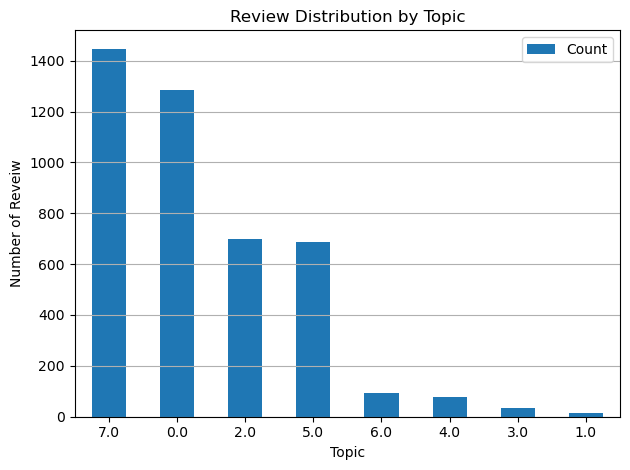

In [20]:
# 각 리뷰의 가장 확률 높은(지배적인) 토픽을 데이터프레임에 추가
def get_dominant_topic(lda_model, bow_vector):
    """BoW 벡터를 입력받아 해당 문서의 지배적인 토픽과 확률을 반환하는 함수"""
    # 문서의 토픽 분포 가져옴
    topic_distribution = lda_model.get_document_topics(bow_vector)
    
    # 확률이 가장 높은 토픽 지정
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    
    # (토픽 ID, 확률) 튜플을 반환
    return dominant_topic[0], dominant_topic[1]

# 모든 리뷰에 대해 지배적인 토픽을 찾아 데이터프레임에 추가
processed_reviews[['dominant_topic', 'topic_probability']] = processed_reviews['tokens'].apply(
    lambda tokens: pd.Series(get_dominant_topic(lda_model, dictionary.doc2bow(tokens)))
)

print("데이터프레임에 지배적인 토픽 정보 추가 완료.")
print(processed_reviews[['tokens', 'dominant_topic', 'topic_probability']].head())

# 토픽별 리뷰 수 확인
topic_counts = processed_reviews['dominant_topic'].value_counts().reset_index()
topic_counts.columns = ['Topic', 'Count']
print("\nNuber of Reveiw by Topic:")
print(topic_counts)

# 토픽 분포 시각화
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar', x='Topic', y='Count')
plt.title('Review Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Reveiw')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### (9) 토픽별 대표 리뷰 추출

In [21]:
for topic in range(optimal_num_topics):
    # 토픽별 확률 상위 리뷰 추출
    top_reviews = processed_reviews[processed_reviews['dominant_topic'] == topic].sort_values('topic_probability', ascending=False).head(5)
    print("="*100, "\n", f"Topic Cluster: {topic}")
    display(top_reviews['original_contents'])

 Topic Cluster: 0


83                                                                             그래픽이 화려하며 재밌게 게임을 할 수 있는 전략적인 요소들이 너무 많아서 즐기면서 하기 좋은 것 같아요!!!
497    판타지를 좋아하던 사람으로 게임해 본 후기는 너무 재밌습니다. 이전버전은 해보지 않아서 비교는 어려우나 터치하나하나에 반응하는 바법같은 그래픽들은 시선 끌기 너무 좋았고! 발열은 조금 있지만 스토리보는재미에 시간가는줄 모르고 게임했습니다!
786                                                     게임 그림 음성이 너무 귀엽고 설명도 쉽게 잘 되어 있어서 초보자도 재미있게 즐길수 있습니다~~~ 시간 가는 줄 모르고 단숨에 캐릭터들 쑥쑥 키웠습니다
107                                                                             추억삼아 다운받아 플레이 해봤는데 너무 재밌네요. 진짜 한 번 킬때마다 시간가는줄도 모르고 하게되네요. 👍👍
227                                                                        시간가는줄 모르고 재밌네요ㅎㅎ 턴제인데 그래픽과 애니메이션도 잘 나온 것 같아요. 저는 과금 없이 잘 즐기고 있어요!
Name: original_contents, dtype: object

 Topic Cluster: 1


554    여러콘텐츠에서 특정 스킬을 연속으로 4회 이상 사용하면 후속 스킬을 사용하기 힘듭니다. 예를 들어 강철의 포식자가 있는데요. 이때파스칼스킬의 발동 순서가 꼬이는 경우가 발생할 수 있습니다. 하지만 '스킬 사용 예약 및 순차 대기' 기능이 적용된다면, 플레이어가 원하는 파스칼 스킬의 발동 순서를 미리 예약해두고, 필요할 때 해당 순서의 스킬 사용을 예약함으로써 원치 않는 스킬 발동 없이 의도한 스킬을 자동으로 사용할 수 있게 됩니다. 이는 복잡한 스킬 연계를 손쉽게 자동화하여 플레이 편의성을 크게 향상시킬 것입니다. 더불어, 파스칼과 같이 스킬 쿨타임 초기화 메커니즘을 가진 영웅의 경우, 기존의 단순한 스킬 우선순위 방식으로는 효율적인 활용이 어렵습니다. 따라서, 사전에 스킬을 원하는 순서대로 등록하여, 해당 순서대로만 발동되도록 하는 기능이 반드시 필요하다고 생각합니다. 그러므로 현재의 쿨타임 기반 자동 발동 방식 외에, 새로운 메커니즘의 자동스킬 시스템을 추가하는 것을 제안...
91                                                                                                                                                                                                                                                                                                        플레이어 캐릭터 '나'가 대화에서 선택지도 고르고 여러 캐릭터와 소통하는 모습이 나와서 캐릭터들과 동료가 돼서 모험을 떠나는 것 같은 느낌도 들었어요... 스토리 중간중간에 나오는 컷신과 BGM의 퀄리티도 좋았어요... 전투를 하며 볼 수 있는 스킬 사용 연출도 인상적이서 지나가다 한 대만 쳐도 죽을 것 같은 적 몬스터에도 스킬 연출이 정성스럽게 

 Topic Cluster: 2


22     편의성 관련하여 패치가 이뤄져서 재밌게 플레이 중입니다. 예전에 비해 색다른 재미도 있고요. 그런데 건의사항인데요. 장비 관련입니다. 가방에서 정렬하는 방식 때문에 일일히 확인해야 하고 또 판매할때도 재확인해야 해서 불편합니다. 같은 종류의 장비끼리 정렬할 수 있도록 해주세요. (6성, 4성 상관없이 같은 종류의 장비끼리요.) 기존에는 기본적으로 성급이 낮은 순으로 정렬되지만, 강화된 수치가 높다면 더 상위로 배치되고, 강화 수치가 다르면 같은 종류의 장비끼리 또 묶입니다. (여기서도 암살자, 성기사끼리 또 묶이죠.) 6성 장비는 그렇다고 치더라도, 5성 4성도 그러하니.. 눈에 피로도가 장난이 아닙니다. 심지어 판매하려면 바로 판매가 불가능하니, 템을 다시 일일히 확인 후 팔아야하죠. 이때는 더 번거롭게 두 번씩 눌러줘야 합니다. 이 일련의 과정이 피로도를 게임을 하는 데에 피로도를 생각보다 높입니다. 꼭 개선하여 주시길 부탁드리겠습니다.
115                                                                                                                                                                                                                                                         세븐나이츠 리버스 이용자 입니다. 세븐나이츠 리버스 개발자와 함께 10년 이든 100년 이든 1000년 이든 계속 함께 하고 싶습니다. 앞으로도 개선해 다양한 시스템 과 이벤트 신규모험과 신규영웅 등등 상시적으로 계속 추가하여 유저들과 함께 10년이 아닌 100년이 아닌 1000년이 아닌 계속 함께 즐길수 있도록 긴 여정을 함께 같이 하고 싶습니다. 세븐나이츠 리버스 운영자님들 화이팅 입니다. 사랑합니다. ^^
175                             

 Topic Cluster: 3


847    게스트계정으로 잘하고 있었는대 업데이트후 로그아웃 돼어 게스트계정 안들어가져~ 결제까지 했는데 이게 뭔 짓거리야~~~ 복구할려면 계정아이뒤랑 달라는데 게스트계정아이디를 내가 어떻게 왜우냐~!!!
706                                                                                      보상부족 열쇠부족 원소부족 다부족 그냥 현질게임
574                                                    게스트에서 현질하며 게임하다 계정 연동 하려했는데 갑자기 로그아웃 되고 계정이 잃어버렸습니다 환불좀 해주세요
69                                   이전 세나1처럼 무한 쫄작이 안 되서 재화 수급이 너무 안 됨 이럴거면 쫄작 가이드는 뭐하러 만든건지도 모르겠음 월정액권 질러봤자 무용지물임
575                                      여전한 열쇠의 모자람과 영웅 하나 진화시 원소노가다 등 그냥 원소수급처와 열쇠수급처를 늘리는게 훨 나을듯 (열쇠충전시간도 너무 느림)
Name: original_contents, dtype: object

 Topic Cluster: 4


1397                                                                                                                        세나하자~세나 세나하자~세나 씬나~~~~~
4305                                                                                                                              세나하자 세나 ! 세나하자 세나
1873                                                                                                              세나하자 세나 세나하자 세나 광고 리메이크 해줬으면 좋겠다.
519     세나1 처음나왔쓸때 했던유저 입니다 보상도 처음 세나 시작했쓸대 보상도 없이 시작하고 했던거 기억이 나네요ㅋㅋㅋ 세나 리버스는 처음나오고 보상도 괜찮게 잘주는거 같고 세나1 처음 시작했때보다 좋은거 같습니다 지금처럼 재미있는 세나 만들어나가 주세요~
70                                                                                                        오랜만에 세나 하는재미가 쏠쏠해용ㅋㅋㅋ 원래 유저인데 옛날생각나구 좋네요!
Name: original_contents, dtype: object

 Topic Cluster: 5


2420             1.픽업뽑기 제이브 200회 고봉밥(주변도 대부분 190뽑에 뽑음) 2.사양 최하로 돌려도 발열 + 배터리 소모 속도 빠름 3.캐릭터 강화 확률 50퍼 10개 발라도 0~2강 붙음(이런 경우가 좀 많았음) 4.원정대 고정 슬롯, 원정대 모두 해제버튼, 있으면 좋겠음 5.재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속 재접속
3656    24 울트라 최고 사양 : 버벅임 심함, 발열 심함 고 사양 : 버벅임 있음, 발열 심함 중 사양 : 버벅임 간헐적 있음, 발열 심함 저사양 : 발열 있음 모니터 연결 시 최고사양 : 버벅임 매우 심함, 발열 있음 고사양 : 버벅임 심함, 발열 있음 중 사양 : 버벅임 있음, 발열 있음 저 사양 : 버벅임 있음, 발열 있음 쿨링 패드 사용은 미실시 이 게임을 모바일로 하는 것은 무리가 있음 쿨링 패드가 필연적일 거 같음 모니터 연결의 경우 덱스의 문제로 여겨짐
71                                                                                                    아니 난 아직도 이게임이 이렇게 발열이랑 렉 튕김이 있는 이유를 모르겠음 그래픽이 좋길하나 연출이 좋길 하나 스케일이 크길 하나 그냥 유니티로 만들어도 비슷하게 나올 그래픽을 괜히 언리얼로 만들어서 최적화랑 안정성 개판으로 만듬 심지어 시점이 자유도 아닌 탑뷰 고정 턴제인데 이따위 최적화는...
1406                                                                                                                                                                                                

 Topic Cluster: 6


10     지난 시즌 결투장을 5805점으로 마무리했는데 저는 정상적으로 5000점으로 초기화가 된 반면 몇몇 유저들은 버그로 그대로 점수를 유지해서 손쉽게 레전드 테두리를 보상으로 타네요? 그래놓고 결투장을 임시로 닫지도 않고 공지에는 확인된 사항 목록에 한 줄 띡 추가하고 아무 반응이 없으시네요 상대적 손해본 사람들 대부분이 많은 돈을 과금한 사람들인데 대우가 이런 식이면 앞으로 운영진을 믿고 돈을 쓰기 상당히 고민됩니다 솔직히 지금도 버그가 많고 출시한지 한달이 지났는데도 버그들 방치하는 것까지 다 참았는데 이번 버그까진 참기 힘듭니다 진짜 한탕하고 서비스 종료하려는거 아니면 버그들 조속히 고치시길 바랍니다
48                                                                                                                                                                                                                                                                                         재미있긴 한데 중간에 튕기는건 고치고 계시는 중인 버그인가요? 결투장이나 모험할때 계속 튕기는데 이것 좀 고처주세요
542                                                                                                                               영웅 버그좀 먼저 빨리 고쳐주세요 짜증나서 못하겠습니다. 레이드 결투장 등 영웅들 실제론 죽은 상태이지만 살아있는 모습으로 그대로 있습니다. 결투장은 그거대로 빡치고, 레이드도 살아있는줄 알고 스킬 계산 해놓으면 실제로 눌렀을때 돼서야 죽었다고 뜨네요? 그와중에 계속 서있고요.. 오픈 초기부터 있던 버그인데 언

 Topic Cluster: 7


858                                       영웅강화 확률 10% 10마리면 1마리는 붙여줘야하는거 아니냐? 50%3마리 넣었는데 안 붙는거 말 안된다고 생각하지않음? 25%짜리애들 5마리 갈아넣는데 한마리가 안 붙음 말 안됨 확률버그임
204                                                                                      1개도아까움 확률조작100퍼인게 리세30번인데 좋은건커녕 평타도안뜨고 18니아11유신1벨리카 ㅋㅋ 진짜 싫다
47                                   세나 프리미엄 30000원 짜리 사고 퍼스트 클래스 15000원으로 할인 하길래 샀는데 즉시 지급 되는 것만 들어오고 나머진 안 들어왔는데 의도 된건가요? 의도 된거면 설명을 적어줘야 하는거 아닐까요?
1       아니 뽑기확률 극악이네요 확정에서만 나오고 이건 뭐 하지말라는 소리인가요? 영웅이 좀 나와야 재미있게 하는데 열심히 루비 모아서 뽑으면 나오질 않으니 흥미가 사라지네요 이 다음 루뽑에서 전설 안나오면 접을게요 원작 하던 유저로서 이건 좀 아닌듯 싶습니다
1027                                                                             아니 확정픽업이면 확정이지 그안에 50%가 또잇네? 확정 뜻을모르나 이게임은? 진짜 이상하네; 리뷰 왜 삭제하고 안뜨게함?
Name: original_contents, dtype: object

In [22]:
for topic in range(optimal_num_topics):
    # 토픽별 랜덤 추출
    top_reviews = processed_reviews[processed_reviews['dominant_topic'] == topic].sample(5)
    print("="*100, "\n", f"Topic Cluster: {topic}")
    display(top_reviews['original_contents'])

 Topic Cluster: 0


2898                       재미있게 시작했어요
1476    옛 추억에 플레이 해봤는데 뭐만 하면 튕기고 그러네요
834              현질을 안하면 초반부분은 좀 힘들어요
4293                                👍
2448                        세나1 느낌 좋군
Name: original_contents, dtype: object

 Topic Cluster: 1


1439                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                세나1이 더빙이나 타격감 스킬들이 훨 나음
91                                                                                                                                                                                                                                                                                                         플레이어 캐릭터 '나'가 대화에서 선택지도 고르고 여러 캐릭터와 소통하는 모습이 나와서 캐릭터들과 동료가 돼서 모험을 떠나는 것 같은 느낌도 들었어요... 스토리 중간중간에 나오는 컷신과 BGM의 퀄리티도 좋았어요... 전투를 하며 볼 수 있는 스킬 사용 연출도 인상적이서 지나가다 한 대만 쳐도 죽을 것 같은 적 몬스터에도 스킬 연출이 정성스럽

 Topic Cluster: 2


2855                                                                                                                                                                                                                                                                                  튜토리얼 드럽게기네
3607                                                                                                                                                                                                                                                                 겁나튕ㅅ김3~5분접속하면 계속팅김 폰2개 다 튕김
1907                                                                                                    재미있음. 단, 재화 수급이 헬임. 과금(루비사용)을 해야만 그나마 수급이 됨. 물론, 초반이라서 뽑기를 빨리 끝내놓고 난 뒤는 루비가 제법 모이긴 하지만 무과금들은 추후 나올 신규캐릭 육성을 위해 비축해야되기 때문에 쉽게 루비사용이 힘들어짐. 그때문에 시간을 두고 게임을해야됨. 느긋하게 게임한다손 치면 뭐 짜증나긴해도 할만함.
4062                                                                                                                                 

 Topic Cluster: 3


2148    옛날 생각하면서 정말 재미있게 잘하고 있습니다 그런데 원소 에너지를 모으는게 너무 힘든데 예전처럼 원소 케릭터처럼 만들어서 영웅 진화시킬때 하나만 사용하는 방식이 더 좋을것 같습니다
3549                                                                     쫄작 불가능하게 열쇠 가격 올려놓음, 월정액 강제하는 수준의 bm
355            재밋게 플레이 하고있었습니다. 제가 게스트로 게임하다 연동깜빡하고 안하다 오늘 들어가면 연동할 생각이였습니다만 접속하니 전까지 사용하던 계정이 사라졌습니다. 도와주세요ㅜ
389                                                                                   구글계정 로그인 안되고 팅기네요...-_-
1313                                                       버그는 버그대로 쫄은 쫄대로 부족합니다 현질을 해도 부족하면 무자본들은 어케 살아남습니까?
Name: original_contents, dtype: object

 Topic Cluster: 4


3708      아니.. 한국한정서비스면.. 리소스 받기전에.. 튜토하기전에 알려줘야죠.. 다하고나서 서비스안한다고 하면.... 하..
1911                                                          버그만 없으면 재미 굿국굿
599                                                           걍 세나1 다시 댈꼬 와줘
329     시즌1부터 했었는데 디자인과 그림체 스킬작동시 에니메이션이 너무 멋지고 게임 할 맛 납니다 너무 재미있어요~ 세나 화이팅~
2918                                             세나 신작이 나와서 옛 버전보다 화질이 좋습니다.
Name: original_contents, dtype: object

 Topic Cluster: 5


2166                           발열 오짐
158                           발열 잡아라
776                         전투중 자꾸튕김
2922    접속을하면 계속 로그인 오류랑 재접속하라고 팅깁니다
439              발열개심함 손난로 인가요? 개선좀요
Name: original_contents, dtype: object

 Topic Cluster: 6


1305                                                                                 툭하면게임튕겨요 제발조치좀...
3474                                           자꾸 튕기는데 서버 문제 해결 시급하고 음.. 미흡한게 많아 보이는데 너무 성급하게 출시한게 아닌지
48                                    재미있긴 한데 중간에 튕기는건 고치고 계시는 중인 버그인가요? 결투장이나 모험할때 계속 튕기는데 이것 좀 고처주세요
1566    '결투장 로딩화면에서 멈추는 현상' 좀 고쳐주세요. 그리고 그로인해 사라진 결투장 티켓, 깎인 점수도 배상해주세요. 배상이 불가능하다면 그에 맞는 대처 부탁드립니다...
873                                                                             버그고치면 4점짜리겜인데 버그 너무많아요
Name: original_contents, dtype: object

 Topic Cluster: 7


2785                                  겜은 재밌는거 같은데 화면 다른앱으로 조금이라도 전환되는수간 재접속 해야한다고 오류가 도대체 몇번이 뜨는건가요....
1317                                                         넷마블도 한물간나? 서버관리가 안되나요 접속이 안돼 첨도아니면서 아마추어같네
425                                                                                           에휴 추억팔이 겜
968                                                                                           재밋음!!!!!!
113     너무 버그가 많다. 별의 별 버그가많다. 영웅이 데미지를 입어도 표기가 안되거나. 모험 돌때 시작부터 영웅하나가 죽은걸로 표시되서 스킬도못쓰거나 레이드는 돌때마다 튕긴다.
Name: original_contents, dtype: object

#### (10) 토픽 이름 지정 및 해석

In [23]:
# 토픽 이름 정의 (4개 기준)
topic_names = {
    0: "Optimization",
    1: "Original",
    2: "Bug",
    3: "Play Design"
}

# 토픽 이름을 데이터프레임에 추가
processed_reviews['topic_name'] = processed_reviews['dominant_topic'].map(topic_names)

# 토픽 이름별 리뷰 분포 확인
topic_name_distribution = processed_reviews['topic_name'].value_counts()
print("\n토픽 이름별 리뷰 분포:")
print(topic_name_distribution)


토픽 이름별 리뷰 분포:
topic_name
Optimization    1284
Bug              698
Play Design       34
Original          13
Name: count, dtype: int64


### Words Frequency

In [24]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [25]:
# 모든 리뷰의 토큰 리스트를 하나로 합치기
all_tokens = [token for tokens in processed_reviews['noun_tokens'] for token in tokens]

# 단어 빈도 계산
word_counts = Counter(all_tokens)

# 상위 빈도 단어 추출 및 데이터프레임화
frequency = 30
top_frequency = word_counts.most_common(frequency)

keyword_list = []
frequency_list = []

for i in range(0, len(top_frequency)):
    keyword_list.append(top_frequency[i][0])
    frequency_list.append(top_frequency[i][1])

top_frequency_dictionary = {
    'keyword' : keyword_list
    , 'frequency' : frequency_list
}

top_frequency_df = pd.DataFrame(top_frequency_dictionary)
top_frequency_df.tail()

KeyError: 'noun_tokens'

In [ ]:
# barplot 시각화
plt.figure(figsize=(12, 5))
plt.bar(top_frequency_df['keyword'], top_frequency_df['frequency'])
plt.xticks(rotation=45)

plt.show()